# Import Libraries

In [20]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import albumentations as A
import numpy as np
from albumentations.pytorch import ToTensorV2


## Data Transformations

We first start with defining our data transformations. We need to think what our data is and how can we augment it to correct represent images which it might not see otherwise.


In [21]:

a_train_transforms = A.Compose([
    A.PadIfNeeded(min_height=36, min_width=36, always_apply=True, p=1),
    A.RandomCrop(height=32, width=32, always_apply=True, p=1),
    A.HorizontalFlip(p=0.5),
    A.CoarseDropout(max_holes=1, max_height=8, max_width=8, min_holes=1, min_height=8, min_width=8,always_apply=False,fill_value=(0.5, 0.5, 0.5)),
    A.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
    ToTensorV2()
])

a_test_transforms = A.Compose([
    A.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
    ToTensorV2()
])

# Dataset and Creating Train/Test Split

In [22]:
def get_augmentation(transforms):
    return lambda img: transforms(image=np.array(img))['image']
train = datasets.CIFAR10('./data', train=True, download=True, transform=get_augmentation(a_train_transforms))
test = datasets.CIFAR10('./data', train=False, download=True, transform=get_augmentation(a_test_transforms))

Files already downloaded and verified
Files already downloaded and verified


# Dataloader Arguments & Test/Train Dataloaders


In [23]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=512, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


In [24]:
len(train_loader)

98

# The model
Let's start with the model we first saw

In [25]:
import torch.nn.functional as F
dropout_value = 0.05
from model import CustomResnet


# Model Params
Can't emphasize on how important viewing Model Summary is.
Unfortunately, there is no in-built model visualizer, so we have to take external help

In [26]:
# !pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = CustomResnet().to(device)
summary(model, input_size=(3, 32, 32))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
            Conv2d-4          [-1, 128, 32, 32]          73,728
         MaxPool2d-5          [-1, 128, 16, 16]               0
       BatchNorm2d-6          [-1, 128, 16, 16]             256
              ReLU-7          [-1, 128, 16, 16]               0
            Conv2d-8          [-1, 128, 16, 16]         147,456
       BatchNorm2d-9          [-1, 128, 16, 16]             256
             ReLU-10          [-1, 128, 16, 16]               0
           Conv2d-11          [-1, 128, 16, 16]         147,456
      BatchNorm2d-12          [-1, 128, 16, 16]             256
             ReLU-13          [-1, 128, 16, 16]               0
           Conv2d-14          [-1,

# Training and Testing

All right, so we have 24M params, and that's too many, we know that. But the purpose of this notebook is to set things right for our future experiments.

Looking at logs can be boring, so we'll introduce **tqdm** progressbar to get cooler logs.

Let's write train and test functions

In [27]:
# from utils import train, test



from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, criterion, scheduler, epoch):
  model.train()
  pbar = tqdm(train_loader)

  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes.
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = criterion(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()
    scheduler.step()

    # Update pbar-tqdm

    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)


    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader, criterion):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item()    # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

    test_acc.append(100. * correct / len(test_loader.dataset))

In [28]:
!pip install torch-lr-finder


In [29]:
from utils import get_lr
from torch_lr_finder import LRFinder



In [30]:
optimizer = optim.Adam(model.parameters(), lr=0.03, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss(reduction="sum")

  0%|          | 0/98 [00:00<?, ?it/s]

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 8.18E-02


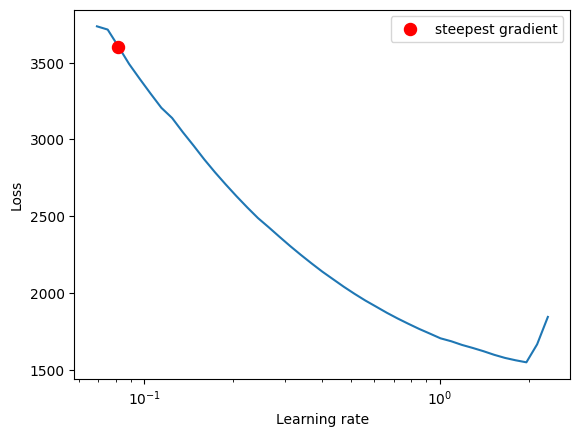

In [31]:

lr_finder = LRFinder(model, optimizer, criterion, device)
lr_finder.range_test(train_loader, end_lr=100, num_iter=len(train_loader))
lr_finder.plot()
lr_finder.reset()

In [32]:
from torch.optim.lr_scheduler import StepLR
from torch.optim.lr_scheduler import OneCycleLR

model =  CustomResnet().to(device)

optimizer = optim.Adam(model.parameters(), lr=8.18E-02)

EPOCHS = 24
scheduler = OneCycleLR(
    optimizer,
    max_lr = 8.18E-02,
    steps_per_epoch = len(train_loader),
    epochs = EPOCHS,
    pct_start = 5/EPOCHS,
    div_factor = 100,
    three_phase = False,
    final_div_factor = 100,
)

for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, criterion, scheduler, epoch)
    print("learning rate : ",get_lr(optimizer))
    test(model, device, test_loader, criterion)

EPOCH: 0


Loss=359.37005615234375 Batch_id=97 Accuracy=52.40: 100%|██████████| 98/98 [00:23<00:00,  4.23it/s]

learning rate :  0.004574109402633093



Test set: Average loss: 1.2888, Accuracy: 5925/10000 (59.25%)

EPOCH: 1


Loss=332.682861328125 Batch_id=97 Accuracy=69.04: 100%|██████████| 98/98 [00:23<00:00,  4.18it/s]

learning rate :  0.015401564343165104



Test set: Average loss: 1.0173, Accuracy: 6878/10000 (68.78%)

EPOCH: 2


Loss=282.7589416503906 Batch_id=97 Accuracy=73.80: 100%|██████████| 98/98 [00:19<00:00,  5.10it/s]

learning rate :  0.02876627575700499



Test set: Average loss: 0.8324, Accuracy: 7330/10000 (73.30%)

EPOCH: 3


Loss=209.6881103515625 Batch_id=97 Accuracy=78.36: 100%|██████████| 98/98 [00:19<00:00,  5.13it/s]

learning rate :  0.039543172940317284



Test set: Average loss: 0.6979, Accuracy: 7632/10000 (76.32%)

EPOCH: 4


Loss=157.37120056152344 Batch_id=97 Accuracy=82.50: 100%|██████████| 98/98 [00:20<00:00,  4.82it/s]

learning rate :  0.0435999689741738



Test set: Average loss: 0.7001, Accuracy: 7819/10000 (78.19%)

EPOCH: 5


Loss=186.1405487060547 Batch_id=97 Accuracy=84.44: 100%|██████████| 98/98 [00:19<00:00,  5.07it/s]

learning rate :  0.043296622154502105



Test set: Average loss: 0.5855, Accuracy: 8087/10000 (80.87%)

EPOCH: 6


Loss=126.17070007324219 Batch_id=97 Accuracy=86.26: 100%|██████████| 98/98 [00:19<00:00,  5.12it/s]

learning rate :  0.04240696298468443



Test set: Average loss: 0.5603, Accuracy: 8294/10000 (82.94%)

EPOCH: 7


Loss=127.02144622802734 Batch_id=97 Accuracy=87.52: 100%|██████████| 98/98 [00:20<00:00,  4.73it/s]

learning rate :  0.04095525904770504



Test set: Average loss: 0.4358, Accuracy: 8564/10000 (85.64%)

EPOCH: 8


Loss=124.30274963378906 Batch_id=97 Accuracy=88.68: 100%|██████████| 98/98 [00:19<00:00,  5.09it/s]

learning rate :  0.038981109042655



Test set: Average loss: 0.4389, Accuracy: 8581/10000 (85.81%)

EPOCH: 9


Loss=103.0173568725586 Batch_id=97 Accuracy=89.97: 100%|██████████| 98/98 [00:19<00:00,  5.14it/s]

learning rate :  0.036538362635447096



Test set: Average loss: 0.4731, Accuracy: 8599/10000 (85.99%)

EPOCH: 10


Loss=84.8431625366211 Batch_id=97 Accuracy=91.05: 100%|██████████| 98/98 [00:20<00:00,  4.87it/s]

learning rate :  0.03369365158030532



Test set: Average loss: 0.3880, Accuracy: 8839/10000 (88.39%)

EPOCH: 11


Loss=79.3047866821289 Batch_id=97 Accuracy=91.85: 100%|██████████| 98/98 [00:19<00:00,  5.04it/s]

learning rate :  0.030524572179205678



Test set: Average loss: 0.4453, Accuracy: 8692/10000 (86.92%)

EPOCH: 12


Loss=63.58964920043945 Batch_id=97 Accuracy=92.78: 100%|██████████| 98/98 [00:19<00:00,  5.07it/s]

learning rate :  0.02711756865703673



Test set: Average loss: 0.3653, Accuracy: 8897/10000 (88.97%)

EPOCH: 13


Loss=70.88088989257812 Batch_id=97 Accuracy=93.72: 100%|██████████| 98/98 [00:20<00:00,  4.86it/s]

learning rate :  0.023565575188487918



Test set: Average loss: 0.3637, Accuracy: 8922/10000 (89.22%)

EPOCH: 14


Loss=45.249366760253906 Batch_id=97 Accuracy=94.55: 100%|██████████| 98/98 [00:19<00:00,  5.03it/s]

learning rate :  0.01996548089602533



Test set: Average loss: 0.3486, Accuracy: 8994/10000 (89.94%)

EPOCH: 15


Loss=71.51414489746094 Batch_id=97 Accuracy=95.51: 100%|██████████| 98/98 [00:19<00:00,  5.07it/s]

learning rate :  0.01641548696720195



Test set: Average loss: 0.4497, Accuracy: 8877/10000 (88.77%)

EPOCH: 16


Loss=49.2148551940918 Batch_id=97 Accuracy=96.07: 100%|██████████| 98/98 [00:19<00:00,  5.02it/s]

learning rate :  0.013012427982252567



Test set: Average loss: 0.3320, Accuracy: 9071/10000 (90.71%)

EPOCH: 17


Loss=26.141571044921875 Batch_id=97 Accuracy=97.03: 100%|██████████| 98/98 [00:19<00:00,  4.97it/s]

learning rate :  0.009849130519173913



Test set: Average loss: 0.3073, Accuracy: 9185/10000 (91.85%)

EPOCH: 18


Loss=26.846439361572266 Batch_id=97 Accuracy=97.72: 100%|██████████| 98/98 [00:19<00:00,  5.09it/s]

learning rate :  0.007011881086657741



Test set: Average loss: 0.2881, Accuracy: 9240/10000 (92.40%)

EPOCH: 19


Loss=34.99124526977539 Batch_id=97 Accuracy=98.07: 100%|██████████| 98/98 [00:19<00:00,  5.01it/s]

learning rate :  0.004578072453065795



Test set: Average loss: 0.2943, Accuracy: 9250/10000 (92.50%)

EPOCH: 20


Loss=5.546611309051514 Batch_id=97 Accuracy=98.48: 100%|██████████| 98/98 [00:20<00:00,  4.85it/s]

learning rate :  0.0026140925734568876



Test set: Average loss: 0.2923, Accuracy: 9252/10000 (92.52%)

EPOCH: 21


Loss=9.470444679260254 Batch_id=97 Accuracy=98.72: 100%|██████████| 98/98 [00:19<00:00,  5.02it/s]

learning rate :  0.0011735136992332938



Test set: Average loss: 0.2889, Accuracy: 9269/10000 (92.69%)

EPOCH: 22


Loss=19.957921981811523 Batch_id=97 Accuracy=98.84: 100%|██████████| 98/98 [00:19<00:00,  4.93it/s]

learning rate :  0.0002956310667749886



Test set: Average loss: 0.2869, Accuracy: 9270/10000 (92.70%)

EPOCH: 23


Loss=16.586658477783203 Batch_id=97 Accuracy=98.91: 100%|██████████| 98/98 [00:20<00:00,  4.87it/s]

learning rate :  4.391025826204788e-06



Test set: Average loss: 0.2868, Accuracy: 9274/10000 (92.74%)



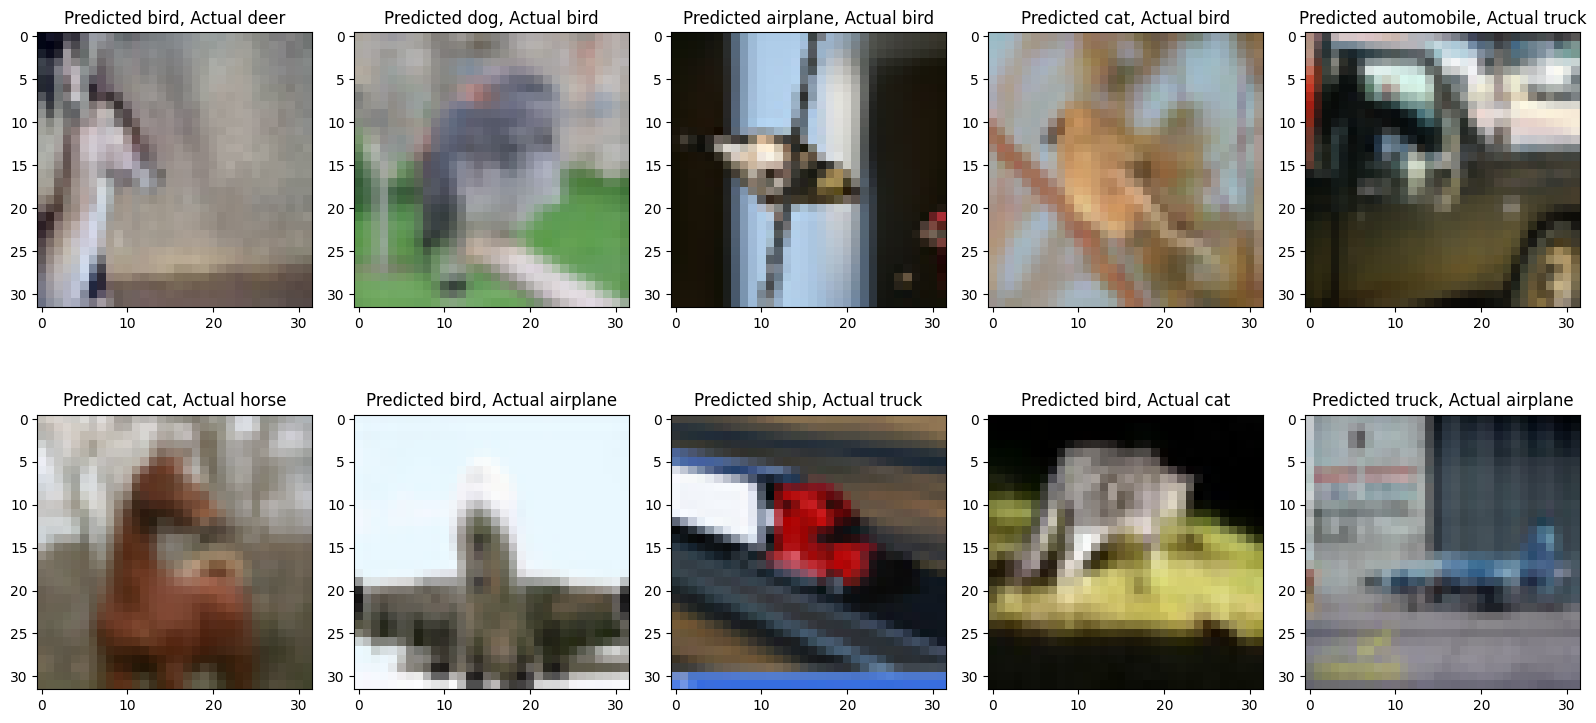

In [33]:
import matplotlib.pyplot as plt
import numpy as np

class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

def get_incorrect_images(model,test_loader,n=10):
  incorrect_images = []
  predicted_labels = []
  correct_labels = []
  for data, target in test_loader:
    data, target = data.to(device), target.to(device)
    output = model(data)
    pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    incorrect_items = pred.ne(target.view_as(pred))
    incorrect_indices = incorrect_items.view(-1).nonzero().view(-1)
    predicted_labels.extend([item.item() for item in pred[incorrect_indices[:n-len(incorrect_images)]]])
    correct_labels.extend([item.item() for item in target.view_as(pred)[incorrect_indices[:n-len(incorrect_images)]]])
    incorrect_images.extend([item for item in data[incorrect_indices[:n-len(incorrect_images)]]])
    if len(incorrect_images)==n:
      break
  return incorrect_images,predicted_labels,correct_labels

def imshow(img):
  img = img / 2 + 0.5     # Unnormalize
  npimg = img
  npimg = np.clip(npimg, 0, 1)  # Add this line to clip the values
  return np.transpose(npimg, (1, 2, 0))  # Convert from Tensor image

fig, axes = plt.subplots(2, 5, figsize=(16, 8))

incorrect_images,predicted_labels,correct_labels = get_incorrect_images(model,test_loader,n=10)

for i, image_tensor in enumerate(incorrect_images):
    ax = axes[i // 5, i % 5]  # Get the location of the subplot
    image = image_tensor.cpu().numpy()
    ax.imshow(imshow(image))  # Display the image
    ax.set_title(f"Predicted {class_names[predicted_labels[i]]}, Actual {class_names[correct_labels[i]]}")  # Set the title as the index

plt.tight_layout()  # To provide sufficient spacing between subplots
plt.show()